# CIFAR10 + DeepTuner

- 1. 그림에 맞게 딥러닝 모델을 잘 설계하였는가?
- 2. 잘못 들어간 test label들을 수정하였는가?
- 3. KerasTuner로 하이퍼파라미터 튜닝을 진행하였는가?	

In [4]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 129 kB 6.0 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [15]:
import tensorflow as tf
import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

In [78]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [64]:
x_train.shape, y_train.shape, x_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3))

In [16]:
# fix the labels

cifar10_class_names = {
    0: 'airplane', 
    1: 'automobile', 
    2: 'bird', 
    3: 'cat', 
    4: 'deer',
    5: 'dog', 
    6: 'frog', 
    7: 'horse', 
    8: 'ship', 
    9: 'truck'
}

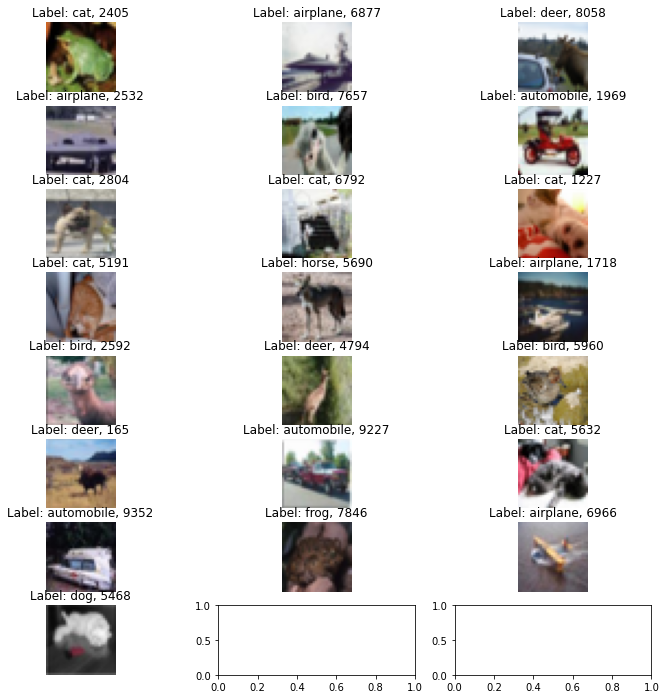

In [65]:
image_ids = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966, 5468]

num_imges = len(image_ids)
num_rows = (num_imges + 2) // 3
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12,12))

for i, img_id in enumerate(image_ids):
    
    row = i // num_cols
    col = i % num_cols
    
    image = x_test[img_id]
    label = y_test[img_id][0]
    
    axes[row, col].imshow(image)
    axes[row, col].set_title(f'Label: {cifar10_class_names[label]}, {img_id}')
    axes[row, col].axis('off')
    
plt.show()

In [79]:
image_ids = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966, 5468]

corrected_label =  [6, 8, 7, 1, 7, 1, 5, 3, 5, 5, 5, 8, 4, 2, 3, 4, 9, 5, 9, 3, 8, 3]

for i, img_id in enumerate(image_ids):
    y_test[img_id] = corrected_label[i]

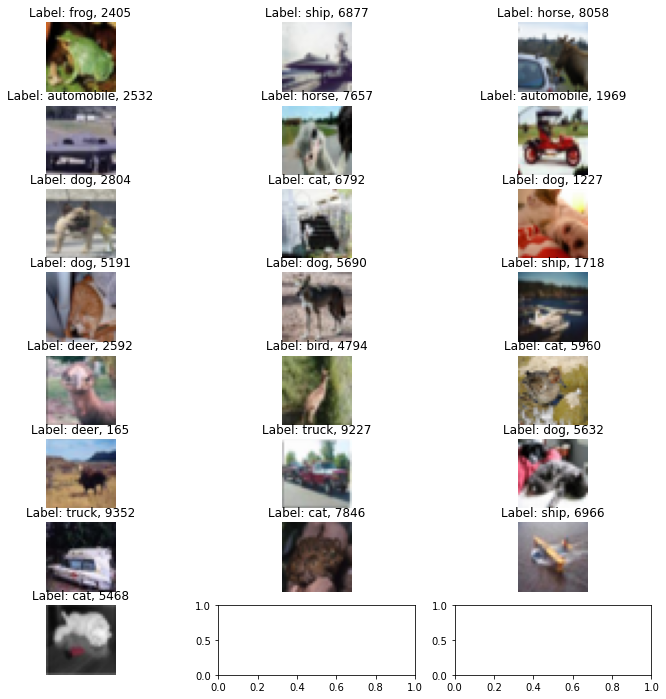

In [67]:
image_ids = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966, 5468]

num_imges = len(image_ids)
num_rows = (num_imges + 2) // 3
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12,12))

for i, img_id in enumerate(image_ids):
    
    row = i // num_cols
    col = i % num_cols
    
    image = x_test[img_id]
    label = y_test[img_id][0]
    
    axes[row, col].imshow(image)
    axes[row, col].set_title(f'Label: {cifar10_class_names[label]}, {img_id}')
    axes[row, col].axis('off')
    
plt.show()

In [68]:
# build model

from keras.models import Sequential
from keras.layers import Dense, Conv2D, AveragePooling2D, Flatten, BatchNormalization, Dropout
from keras_tuner.tuners import RandomSearch
import numpy as np

In [80]:
# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

In [70]:

class DeepTuner(kt.Tuner):
    
    def run_trial(self, trial, X, y, val_data, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(X, y, batch_size = trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)
        X_val, y_val = val_data
        eval_scores = model.evaluate(X_val, y_val)
        
        return {name: value for name, value in zip(
            model.metrics_names, eval_scores)}
    

In [71]:
def build_model(hp):
    model = Sequential()
    
    # Conv2D layer
    model.add(Conv2D(hp.Int('conv2d_filters', min_value=16, max_value=64, step=16), (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(AveragePooling2D())
    
    # Dropout layer
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=248, step=64), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_rate_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [72]:
# tuner

my_keras_tuner = DeepTuner(
    oracle = kt.oracles.BayesianOptimizationOracle(
        objective = kt.Objective('accuracy', 'max'),
        max_trials=5,
        seed=42
    ),
    hypermodel=build_model,
    overwrite=True,
    project_name='cifar10_model'
)

In [81]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [74]:
# search!

my_keras_tuner.search(X_train,
                     tf.keras.utils.to_categorical(y_train),
                     val_data=(X_val, tf.keras.utils.to_categorical(y_val)),
                     epochs=3)

Trial 5 Complete [00h 00m 16s]
accuracy: 0.6043999791145325

Best accuracy So Far: 0.6269999742507935
Total elapsed time: 00h 01m 59s


In [75]:
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = build_model(best_hps)
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 30, 30, 48)        1344      
_________________________________________________________________
batch_normalization_52 (Batc (None, 30, 30, 48)        192       
_________________________________________________________________
average_pooling2d_26 (Averag (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 15, 15, 48)        0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 10800)             0         
_________________________________________________________________
dense_52 (Dense)             (None, 128)               1382528   
_________________________________________________________________
batch_normalization_53 (Batc (None, 128)             

In [82]:
y_train = tf.keras.utils.to_categorical(y_train)

In [83]:
model.fit(X_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8366 - accuracy: 0.7140
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7402 - accuracy: 0.7469
Epoch 3/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6683 - accuracy: 0.7756
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6096 - accuracy: 0.7947
Epoch 5/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5464 - accuracy: 0.8197
Epoch 6/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5035 - accuracy: 0.8335
Epoch 7/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.4563 - accuracy: 0.8492
Epoch 8/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.4159 - accuracy: 0.8626
Epoch 9/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3792 - accuracy: 0.8756
Epoch 10/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.345

In [86]:
y_test = tf.keras.utils.to_categorical(y_test)

model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.0796 - accuracy: 0.6612


[1.079581618309021, 0.6611999869346619]

In [87]:
save_path = os.getenv('HOME') + '/aiffel/CustomM/mlops/PJT_best_model'
fname = os.path.join(save_path, 'model')
model.save(fname)

INFO:tensorflow:Assets written to: /aiffel/aiffel/CustomM/mlops/PJT_best_model/model/assets
